<a href="https://colab.research.google.com/github/hkayesh/causal-qa/blob/master/Hassanzadeh_CausalQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install faiss-gpu

     |████████████████████████████████| 41.0MB 73kB/s 


In [0]:
! pip install sentence-transformers

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 450kB 8.9MB/s 
     |████████████████████████████████| 1.0MB 16.3MB/s 
     |████████████████████████████████| 870kB 21.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.5-cp36-none-any.whl size=64943 sha256=222e3f25abe7f7339cc099d16d6ee8ff11d2623b7762d85e487ae5cc99a77bf9
  Stored in directory: /root/.cache/pip/wheels/b4/ce/39/5bbda8ac34eb52df8c6531382ca077773fbfcbfb6386e5d66c
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=1dee14d414270ed55574c2b7e46ce4174095f35d87765a54869698d8cda79467
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sentence-transformers sacremoses


In [0]:
import re
import faiss  
import scipy.spatial
import numpy as np
import pandas as pd

from google.colab import drive
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, matthews_corrcoef

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
RANDOM_SEED = 1
TOP_N = 10
EMBEDDING_DIM = 768
NUM_CAUSAL_SENTENCES = 100000
THRESHOLD_SELECTION = False
DATASET_DIR_PATH = 'gdrive/My Drive/Research Data/CausalQA/datasets/'
CAUSAL_SENTENCES_FILE_PATH = 'gdrive/My Drive/Research Data/CausalQA/causal_pairs_1M_articles.csv'
CAUSAL_SENTENCES_EMBD_FILE_PATH = 'gdrive/My Drive/Research Data/CausalQA/causal_pairs_1M_articles_embds.txt'
NOT_CAUSAL_SENTS_FILE_PATH = 'gdrive/My Drive/Research Data/CausalQA/not_causal_pairs_1M_sents.csv'

### Load datasets

In [0]:
causal_pairs_df = pd.read_csv(CAUSAL_SENTENCES_FILE_PATH, nrows=NUM_CAUSAL_SENTENCES, lineterminator='\n', error_bad_lines=False)
print(causal_pairs_df.shape)
causal_pairs_df.head()

(100000, 3)


,sentence,sequence_a,sequence_b
0,the postal order was chosen because of its cen...,its central location and its proximity to the ...,the postal order was chosen
1,"posted on sep 22, 2015\rif you were a basketba...",you were a basketball fan who was born in the 80s,you were lucky enough to witness the beauty th...
2,individual dreams and visions have been aborte...,words of death spoken over them,individual dreams and visions have been aborted
3,homes and marriages have been destroyed becaus...,poisonous words,homes and marriages have been destroyed
4,companies and businesses have fallen because o...,words of envy and jealousy,companies and businesses have fallen


  Created wheel for apyori: filename=apyori-1.1.2-cp36-none-any.whl size=5975 sha256=a0c4187dedce1edd75922d0c4aecef50527f95fffdea4eeff096fdcadd1e54d1
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
18
15


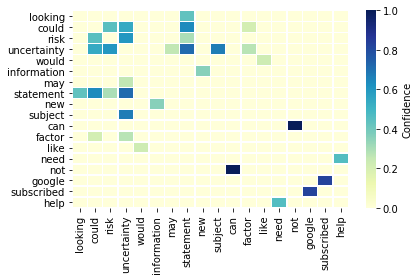

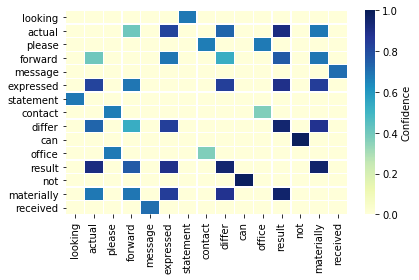

In [0]:
! pip install apyori

import nltk
 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import Word
from nltk.stem import WordNetLemmatizer 
import seaborn as sns
import matplotlib.pyplot as plt

from apyori import apriori

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


def get_heatmap_matrix(data_frame, target_col):
  
  words = list(set(data_frame['word_1'].tolist() + data_frame['word_2'].tolist()))
  heatmap_matrix = np.zeros((len(words), len(words)))
  for index, row in data_frame.iterrows():
    i = words.index(row['word_1'])
    j = words.index(row['word_2'])

    value = row[target_col]

    heatmap_matrix[i][j] = value
    heatmap_matrix[j][i] = value
  print(len(words))
  return pd.DataFrame(heatmap_matrix, columns=words, index=words)

def get_association_rules(cause_token_lists, min_support=0.00045, 
                          min_confidence=0.2, min_lift=3, min_length=2, max_length=2):
  
  results = list(apriori(cause_token_lists, min_support=min_support, 
                         min_confidence=min_confidence, min_lift=min_lift, 
                         min_length=min_length, max_length=max_length))
  assoc_rules = []

  for item in results:
    pair = list(item[0]) 
    support = item[1]
    confidence = item[2][0][2]
    lift = item[2][0][3]
    assoc_rules.append((pair[0], pair[1], support, confidence, lift))

  assoc_rules_df = pd.DataFrame(assoc_rules, columns=['word_1', 'word_2', 'support', 'confidence', 'lift'])
  assoc_rules_df.sort_values(by=['lift'])

  return assoc_rules_df

# generate heatmap for causal phrases
lemmatizer = WordNetLemmatizer()
phrase_max_len = 64

causal_pairs_df['sequence_a'] = causal_pairs_df['sequence_a'].apply(lambda x: x.lower())
causal_pairs_df['sequence_a'] = causal_pairs_df['sequence_a'].str.replace('[^\w\s]','')
stop = stopwords.words('english')
causal_pairs_df['sequence_a'] = causal_pairs_df['sequence_a'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
cause_token_lists = causal_pairs_df['sequence_a'].apply(lambda x: [lemmatizer.lemmatize(word).strip() for word in word_tokenize(x)]).tolist()
cause_token_lists = [item for item in cause_token_lists if len(item) > 0]
cause_token_lists = [item if len(item) <= phrase_max_len else item[:phrase_max_len] for item in cause_token_lists]

causal_assoc_rules_df = get_association_rules(cause_token_lists, min_support=0.0025)
heatmap_matrix = get_heatmap_matrix(causal_assoc_rules_df, 'confidence')

fig, ax = plt.subplots()
sns.heatmap(heatmap_matrix, vmax=1, vmin=0, cmap='YlGnBu', linewidths=.3, ax=ax, 
            cbar_kws={'label': 'Confidence'});
plt.tight_layout()
plt.savefig('causal_heatmap.pdf')

# generate heatmap for effect phrases
causal_pairs_df['sequence_b'] = causal_pairs_df['sequence_b'].apply(lambda x: x.lower())
causal_pairs_df['sequence_b'] = causal_pairs_df['sequence_b'].str.replace('[^\w\s]','')
causal_pairs_df['sequence_b'] = causal_pairs_df['sequence_b'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
effect_token_lists = causal_pairs_df['sequence_b'].apply(lambda x: [lemmatizer.lemmatize(word).strip() for word in word_tokenize(x)]).tolist()
effect_token_lists = [item for item in effect_token_lists if len(item) > 0]
effect_token_lists = [item if len(item) <= phrase_max_len else item[:phrase_max_len] for item in effect_token_lists]

effect_assoc_rules_df = get_association_rules(effect_token_lists, min_support=0.002)
heatmap_matrix = get_heatmap_matrix(effect_assoc_rules_df, 'confidence')

fig, ax = plt.subplots()
sns.heatmap(heatmap_matrix, vmax=1, vmin=0, cmap='YlGnBu', linewidths=.3, ax=ax, 
            cbar_kws={'label': 'Confidence'});
plt.tight_layout()
plt.savefig('effect_heatmap.pdf')

#### N-gram statistics

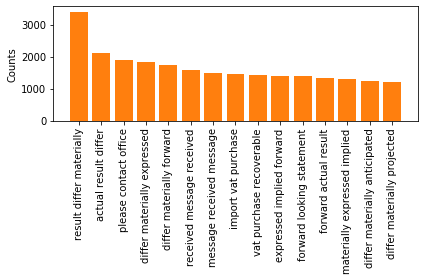

In [0]:
import nltk 
from collections import Counter
from nltk.util import ngrams
import itertools

def display_ngram_bar_chart(data, out_file = None):
  keys = [item[0] for item in data]
  values = [item[1] for item in data]

  y_pos = np.arange(len(keys))

  plt.bar(y_pos, values, align='center', color='C1')
  plt.xticks(y_pos, keys, rotation=90)
  plt.ylabel('Counts')
  plt.tight_layout()
  if out_file is None:
    plt.show()
  else:
    plt.savefig(out_file)

top_n = 15
flatten_causal_tokens = list(itertools.chain.from_iterable(cause_token_lists))
causal_unigrams = Counter(flatten_causal_tokens).most_common(top_n)
causal_bigrams = [(' '.join(item[0]), item[1])for item in Counter(ngrams(flatten_causal_tokens, 2)).most_common(top_n)]
causal_trigrams = [(' '.join(item[0]), item[1])for item in Counter(ngrams(flatten_causal_tokens, 3)).most_common(top_n)]

flatten_effect_tokens = list(itertools.chain.from_iterable(effect_token_lists))
effect_unigrams = Counter(flatten_effect_tokens).most_common(top_n)
effect_bigrams = [(' '.join(item[0]), item[1])for item in Counter(ngrams(flatten_effect_tokens, 2)).most_common(top_n)]
effect_trigrams = [(' '.join(item[0]), item[1])for item in Counter(ngrams(flatten_effect_tokens, 3)).most_common(top_n)]

display_ngram_bar_chart(causal_unigrams, 'causal_unigram_frequency.pdf')
display_ngram_bar_chart(causal_bigrams, 'causal_bigram_frequency.pdf')
display_ngram_bar_chart(causal_trigrams, 'causal_trigram_frequency.pdf')

display_ngram_bar_chart(effect_unigrams, 'effect_unigram_frequency.pdf')
display_ngram_bar_chart(effect_bigrams, 'effect_bigram_frequency.pdf')
display_ngram_bar_chart(effect_trigrams, 'effect_trigram_frequency.pdf')


In [0]:
semeval_file_path = DATASET_DIR_PATH + 'semeval-benchmark-v1.csv'
risk_file_path = DATASET_DIR_PATH + 'risk-models-benchmark-v1.csv'
nato_sfa_file_path = DATASET_DIR_PATH + 'nato-sfa-benchmark-v1.csv'
ce_me_file_path = DATASET_DIR_PATH + 'ce-me-benchmark-v1.csv'
ce_twitter_file_path = DATASET_DIR_PATH + 'twitter-causal-dataset.csv'

sem_eval_df = pd.read_csv(semeval_file_path, names=['cause', 'effect', 'label'], header=None)
sem_eval_df.head()

,cause,effect,label
0,dwarf,emission,causal
1,disease,blindness,causal
2,women,accident,causal
3,reading,rage,causal
4,snowstorm,losses,causal


In [0]:
risk_df = pd.read_csv(risk_file_path, names=['cause', 'effect', 'label'], header=None)
risk_df['cause'] = risk_df['cause'].apply(lambda x: re.sub('\s\[\d+\]$', '', x))  # remove '[n]' from the end
risk_df['effect'] = risk_df['effect'].apply(lambda x: re.sub('\s\[\d+\]$', '', x))  # remove '[n]' from the end
risk_df.head()

,cause,effect,label
0,new competitors,increasing profits for our clients,causal
1,new competitors,"increased speed efficiency, and lower cost",causal
2,"increased speed efficiency, and lower cost",increasing profits for our clients,causal
3,"increased speed efficiency, and lower cost",increasing profits for our clients,causal
4,changing market driving the needs for new busi...,increased importance of bundling products,causal


In [0]:
nato_sfa_df = pd.read_csv(nato_sfa_file_path, names=['cause', 'effect', 'label'], header=None)
nato_sfa_df.head()

,cause,effect,label
0,Increased global inequality,Migration,causal
1,Natural disasters,Unavailability of national military assets due...,causal
2,Increasingly connected human networks,An increasing need to understand human networks,causal
3,Fractured and/or polarized societies,Instability and civil war,causal
4,Fractured and/or polarized societies,Instability along NATO’s border causing large-...,causal


In [0]:
ce_me_df = pd.read_csv(ce_me_file_path, names=['cause', 'effect', 'label'], header=None)
ce_me_df.head()

,cause,effect,label
0,A strong dollar and a low oil price,profits of multinationals have dropped by 25%,causal
1,country increases imports,country decreasing balance of trade,causal
2,plunge in the value of local currency,country decreasing foreign reserves,causal
3,increase in national debt,decrease in real annual economic growth,causal
4,increase in the demand for a currency,rise in the exchange rate,causal


In [0]:
ce_twitter_df = pd.read_csv(ce_twitter_file_path)
ce_twitter_df['label'] = ce_twitter_df['label'].apply(lambda x: 'non_causal' if x == 'not-causal' else x)
ce_twitter_df.head()

,cause,effect,label
0,i ned to be front and centre,it’s al about me,non_causal
1,families truly suport girl-child,we can se that sky to is not the limit,causal
2,blinding youth with pelet guns was a #comonwea...,india would win a gold every hour,non_causal
3,they were so intolerant to an individuals thou...,they cant telecast #comonwealthgames2018 medal...,causal
4,you can't wait until then,you can watch it here:,causal


### Load pretrained model

In [0]:
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:54<00:00, 7.45MB/s]


In [0]:
if not THRESHOLD_SELECTION:
  # Corpus with example sentences

  # corpus = causal_pairs_df['sentence'].tolist()
  # corpus_embeddings = embedder.encode(corpus)
  # corpus_embeddings = np.asarray(corpus_embeddings, dtype='float32')

  corpus_embeddings = np.asarray(np.loadtxt(CAUSAL_SENTENCES_EMBD_FILE_PATH), dtype='float32')
  if NUM_CAUSAL_SENTENCES is not None:
    corpus_embeddings = corpus_embeddings[:NUM_CAUSAL_SENTENCES]

  corpus_embeddings.shape

  faiss_index = faiss.IndexFlatL2(EMBEDDING_DIM)   # build the index
  faiss_index.add(np.asarray(corpus_embeddings, dtype='float32'))     # add vectors to the index

### Eevaluation

In [0]:
def get_bert_sim_scores(faiss_index, sents_embds, corpus_embds, top_n):
  _, index_lists = faiss_index.search(sents_embds, top_n)
  
  bert_sim_scores = []
  for sent_embd, index_list in zip(sents_embds, index_lists):
    top_n_embds = np.asarray([corpus_embds[index] for index in index_list])
    sent_embd = sent_embd.reshape(1, EMBEDDING_DIM)

    bert_sim_score = sum(cosine_similarity(sent_embd, top_n_embds)[0])/len(top_n_embds)
    bert_sim_scores.append(bert_sim_score)

  return bert_sim_scores

def get_c_scores(sim_scores, rvrs_scores):
  c_scores = []
  for sim_score, rvrs_score in zip(sim_scores, rvrs_scores):
    if rvrs_score > 0:
      c_score = sim_score/rvrs_score
    else:
      c_score = sim_score

    c_scores.append(c_score)
  return c_scores 

def get_labels(sim_scores, c_scores, threshold_1=0.91, threshold_2=0.65):
  assert(len(sim_scores) == len(c_scores))

  labels = []
  for sim_score, c_score in zip(sim_scores, c_scores):
    label = 0
    if sim_score >= threshold_1 and c_score >= threshold_2:
      label = 1
    labels.append(label)
  
  return labels

#### Threshold Selection

In [0]:
if THRESHOLD_SELECTION:
  X = causal_pairs_df
  y = pd.Series(['causal'] * len(X))

  X_train, X_valid_causal, y_train, y_valid_causal = train_test_split(X, y, test_size = 0.25, random_state = RANDOM_SEED)
  sentences = X_train['sentence'].tolist()

  X_valid_causal['label'] = y_valid_causal

  X_valid_not_causal = pd.read_csv(NOT_CAUSAL_SENTS_FILE_PATH, nrows=len(X_valid_causal), lineterminator='\n', error_bad_lines=False)
  X_valid_not_causal['label'] = pd.Series(['non_causal'] * len(X))

  X_valid = pd.concat([X_valid_causal, X_valid_not_causal], axis=0, join='outer', ignore_index=False, keys=None,
            levels=None, names=None, verify_integrity=False, copy=True)



  corpus_embeddings = embedder.encode(sentences)
  corpus_embeddings = np.asarray(corpus_embeddings, dtype='float32')

  faiss_index = faiss.IndexFlatL2(EMBEDDING_DIM)   # build the index
  faiss_index.add(np.asarray(corpus_embeddings, dtype='float32'))     # add vectors to the index

In [0]:
if THRESHOLD_SELECTION:
  print('Th1_Th2, Acc, Precision, Recall, F1-score')
  for threshold_1 in np.arange(0.0, 1.0, 0.30):
    for threshold_2 in np.arange(0.0, 1.3, 0.30):
      dataset_df = X_valid

      causes = dataset_df['sequence_a'].tolist()
      effects = dataset_df['sequence_b'].tolist()

      forward_sents = []
      reverse_sents = []

      for cause, effect in zip(causes, effects):
        forward_sents.append(cause + ' may cause ' + effect)
        reverse_sents.append(effect + ' may cause ' + cause)

      forward_sents_embds = np.asarray(embedder.encode(forward_sents), dtype='float32')
      reverse_sents_embds = np.asarray(embedder.encode(reverse_sents), dtype='float32')

      bert_sim_scores = get_bert_sim_scores(faiss_index, forward_sents_embds, corpus_embeddings, TOP_N)
      rvrs_scores = get_bert_sim_scores(faiss_index, reverse_sents_embds, corpus_embeddings, TOP_N)
      bert_c_scores = get_c_scores(bert_sim_scores, rvrs_scores)
      preds = get_labels(bert_sim_scores, bert_c_scores, threshold_1, threshold_2)
      golds = [1 if label == 'causal' else 0 for label in dataset_df['label'].tolist()]
      
      print('{}_{}, {}, {}, {}, {}'.format(threshold_1, threshold_2, 
                                        accuracy_score(golds, preds), 
                                        precision_score(golds, preds), 
                                        recall_score(golds, preds), 
                                        f1_score(golds, preds)))



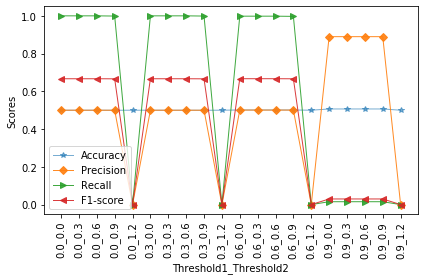

In [0]:
def display_threshold_section_linechart(data, output_file):
    x_axis = data['x_axis']
    y_axis = data['y_axis']

    plt.clf()
    plt.plot(x_axis, y_axis[0], '-*', linewidth=1, alpha=0.6, label='Accuracy')
    plt.plot(x_axis, y_axis[1], '-D', linewidth=1, alpha=0.9, label='Precision')
    plt.plot(x_axis, y_axis[2], '->', linewidth=1, alpha=0.9, label='Recall')
    plt.plot(x_axis, y_axis[3], '-<', linewidth=1, alpha=0.9, label='F1-score')
    
    plt.xticks(rotation=90)
    plt.xlabel('Threshold1_Threshold2')
    plt.ylabel('Scores')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig(output_file)

data = {'y_axis':[[0.5000, 0.5000, 0.5000, 0.4998, 0.5000, 0.5000, 0.5000, 0.5000, 0.4998, 0.5000, 0.5013, 0.5013, 0.5013, 0.5011, 0.5000, 0.5066, 0.5066, 0.5066, 0.5066, 0.5000], 
                  [0.5000, 0.5000, 0.5000, 0.4999, 0.0000, 0.5000, 0.5000, 0.5000, 0.4999, 0.0000, 0.5007, 0.5007, 0.5007, 0.5006, 0.0000, 0.8897, 0.8897, 0.8897, 0.8897, 0.0000],
                  [1.0000, 1.0000, 1.0000, 0.9988, 0.0000, 1.0000, 1.0000, 1.0000, 0.9988, 0.0000, 0.9982, 0.9982, 0.9982, 0.9971, 0.0000, 0.0152, 0.0152, 0.0152, 0.0152, 0.0000],
                  [0.6667, 0.6667, 0.6667, 0.6663, 0.0000, 0.6667, 0.6667, 0.6667, 0.6663, 0.0000, 0.6669, 0.6669, 0.6669, 0.6665, 0.0000, 0.0298, 0.0298, 0.0298, 0.0298, 0.0000]],
        'x_axis': ['0.0_0.0', '0.0_0.3', '0.0_0.6', '0.0_0.9', '0.0_1.2',	'0.3_0.0', '0.3_0.3',	'0.3_0.6', '0.3_0.9', '0.3_1.2', '0.6_0.0', '0.6_0.3', '0.6_0.6', '0.6_0.9', '0.6_1.2', '0.9_0.0', '0.9_0.3', '0.9_0.6', '0.9_0.9', '0.9_1.2']}

output_file = 'hassanzadeh_threshold_selection.pdf'
display_threshold_section_linechart(data, output_file)

#### Hassanzadeh Evaluation

In [0]:
# # Used for the experiments on the original threhsolds
# dataset_items = [('SemEval', sem_eval_df, (0.82, 0.62)), 
#             ('NATO-SFA', nato_sfa_df, (0.94, 0.82)),
#             ('Risk models', risk_df, (0.0, 0.9)), 
#             ('CE_ME', ce_me_df, (0.91, 0.65)),
#             ('CE twitter', ce_twitter_df, (0.94, 0.9))]

# Used for experimenting with common threhsolds
threshold_1 = 0.6  # found from threhsold selection
threshold_2 = 0.3  # found from threhsold selection
dataset_items = [('SemEval', sem_eval_df, (threshold_1, threshold_2)), 
            ('NATO-SFA', nato_sfa_df, (threshold_1, threshold_2)),
            ('Risk Models', risk_df, (threshold_1, threshold_2)), 
            ('CE Pairs', ce_me_df, (threshold_1, threshold_2)),
            ('Twitter', ce_twitter_df, (threshold_1, threshold_2))]

print('Dataset, Acc, Precision, Recall, F1-score')
for dataset_item in dataset_items:
  dataset_name = dataset_item[0]
  dataset_df = dataset_item[1]
  threshold_1, threshold_2 = dataset_item[2]

  causes = dataset_df['cause'].tolist()
  effects = dataset_df['effect'].tolist()

  forward_sents = []
  reverse_sents = []

  for cause, effect in zip(causes, effects):
    forward_sents.append(cause + ' may cause ' + effect)
    reverse_sents.append(effect + ' may cause ' + cause)

  forward_sents_embds = np.asarray(embedder.encode(forward_sents), dtype='float32')
  reverse_sents_embds = np.asarray(embedder.encode(reverse_sents), dtype='float32')

  bert_sim_scores = get_bert_sim_scores(faiss_index, forward_sents_embds, corpus_embeddings, TOP_N)
  rvrs_scores = get_bert_sim_scores(faiss_index, reverse_sents_embds, corpus_embeddings, TOP_N)
  bert_c_scores = get_c_scores(bert_sim_scores, rvrs_scores)
  preds = get_labels(bert_sim_scores, bert_c_scores, threshold_1, threshold_2)
  golds = [1 if label == 'causal' else 0 for label in dataset_df['label'].tolist()]
  
  print('{}, {}, {}, {}, {}'.format(dataset_name, 
                                    accuracy_score(golds, preds), 
                                    precision_score(golds, preds), 
                                    recall_score(golds, preds), 
                                    f1_score(golds, preds)))




Dataset, Acc, Precision, Recall, F1-score
SemEval, 0.5028901734104047, 0.5014492753623189, 1.0, 0.6679536679536681
NATO-SFA, 0.5, 0.5, 1.0, 0.6666666666666666
Risk models, 0.5, 0.5, 1.0, 0.6666666666666666
CE_ME, 0.5, 0.5, 1.0, 0.6666666666666666
Twitter, 0.5010917030567685, 0.5010917030567685, 1.0, 0.6676363636363636


#### Extension Evaluation

In [0]:
def get_labels_by_sim_diff(sim_scores, rvrs_sim_scores, threshold=0.2):
  assert(len(sim_scores) == len(rvrs_sim_scores))

  labels = []
  for sim_score, rvrs_sim_score in zip(sim_scores, rvrs_sim_scores):
    label = 0
    if sim_score > rvrs_sim_score and (sim_score - rvrs_sim_score) >= threshold:
      label = 1
    labels.append(label)
  
  return labels

#### Learn Thresholds

In [0]:
# causal_tuples_file = '/content/gdrive/My Drive/Research Data/CausalQA/causalTuples/nyt_mar30_combo.argsC'

# causes = []
# effects = []

# with open(causal_tuples_file, 'r') as rows:
#   for index, row in enumerate(rows):
#     splits = row.split('-->', 2)
#     cause = re.sub('_[A-Z]+', '', splits[0]).strip().lower()
#     effect = re.sub('_[A-Z]+', '', splits[1]).strip().lower()

#     causes.append(cause)
#     effects.append(effect)

# forward_sents = []
# reverse_sents = []

# for cause, effect in zip(causes, effects):
#   forward_sents.append(cause + ' may cause ' + effect)
#   reverse_sents.append(effect + ' may cause ' + cause)

# forward_sents_embds = np.asarray(embedder.encode(forward_sents), dtype='float32')
# reverse_sents_embds = np.asarray(embedder.encode(reverse_sents), dtype='float32')

# sim_scores = get_bert_sim_scores(faiss_index, forward_sents_embds, corpus_embeddings, TOP_N)
# rvrs_sim_scores = get_bert_sim_scores(faiss_index, reverse_sents_embds, corpus_embeddings, TOP_N)
# c_scores = get_c_scores(sim_scores, rvrs_sim_scores)

# threshold_1 = sum(sim_scores)/len(sim_scores) # 0.8025798410851066
# threshold_2 = sum(c_scores)/len(c_scores) # 1.0048565589436032



#### Evaluation on fixed thresholds

In [0]:
dataset_items = [('SemEval', sem_eval_df), 
            ('NATO-SFA', nato_sfa_df),
            ('Risk Models', risk_df), 
            ('CE pairs', ce_me_df),
            ('CE Twitter', ce_twitter_df)]
print('Dataset, Acc, Precision, Recall, F1-score')
for dataset_item in dataset_items:
  dataset_name = dataset_item[0]
  dataset_df = dataset_item[1]
  # threshold = 0.01
  threshold_1 = 0.8025798410851066
  threshold_2 = 1.0048565589436032

  causes = dataset_df['cause'].tolist()
  effects = dataset_df['effect'].tolist()

  forward_sents = []
  reverse_sents = []

  for cause, effect in zip(causes, effects):
    forward_sents.append(cause + ' may cause ' + effect)
    reverse_sents.append(effect + ' may cause ' + cause)

  forward_sents_embds = np.asarray(embedder.encode(forward_sents), dtype='float32')
  reverse_sents_embds = np.asarray(embedder.encode(reverse_sents), dtype='float32')

  bert_sim_scores = get_bert_sim_scores(faiss_index, forward_sents_embds, corpus_embeddings, TOP_N)
  bert_rvrs_sim_scores = get_bert_sim_scores(faiss_index, reverse_sents_embds, corpus_embeddings, TOP_N)  
  bert_c_scores = get_c_scores(bert_sim_scores, bert_rvrs_sim_scores)
  
  # preds = get_labels_by_sim_diff(bert_sim_scores, bert_rvrs_sim_scores, threshold)
  preds = get_labels(bert_sim_scores, bert_c_scores, threshold_1, threshold_2)
  golds = [1 if label == 'causal' else 0 for label in dataset_df['label'].tolist()]
  
  print('{}, {}, {}, {}, {}\n'.format(dataset_name, 
                                    accuracy_score(golds, preds), 
                                    precision_score(golds, preds), 
                                    recall_score(golds, preds), 
                                    f1_score(golds, preds)))




Dataset, Acc, Precision, Recall, F1-score
SemEval, 0.6127167630057804, 0.8350515463917526, 0.2809248554913295, 0.42041522491349476

NATO-SFA, 0.4745762711864407, 0.43478260869565216, 0.1694915254237288, 0.24390243902439024

Risk Models, 0.503731343283582, 0.50920245398773, 0.2064676616915423, 0.2938053097345133

CE pairs, 0.53125, 0.5520833333333334, 0.33125, 0.41406250000000006

CE Twitter, 0.5054585152838428, 0.56, 0.06100217864923747, 0.1100196463654224

